# Computer Vision - Model Training
*Eleonora Pedrini-Pedroli, Leo Rettich*

The following notebook loads the prepared dataset from a pickle file, defines and trains the classification model and stores the model as a folder to google drive. 

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

### Load the dataset from pickle file.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('gdrive/MyDrive/Computer_Vision/dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [ ]:
print(dataset['data'].shape)
print(dataset['labels'].shape)

(4762, 150, 150, 3)
(4762,)


### Final preparations specific to the training process. 

In [ ]:
data = dataset['data']
labels = dataset['labels']

Perform one-hot encoding on the labels

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

Depending on the number of categories that should be classified by the model, the following blocks are combining mutiple categories to a OTHER category. 

If the model should be trained to classify all the eight categories, the following code blocks can be commented out. 

In [ ]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
new_labels = np.zeros((len(labels), 3))
new_labels[:,:2] = labels[:,:2]
new_labels[:,2] = np.sum(labels[:, 2:], axis=1)
labels = new_labels
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

Split of data into train and test

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

Definition of the data augmentation process. 

`orthogonal_rot` is used as preprocessing function to assure that the image is only rotated by 90, 180 or 270 degrees. 

In [ ]:
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1, 2]))

aug = ImageDataGenerator(
    #rotation_range=20,
    preprocessing_function=orthogonal_rot,
    #zoom_range=0.15,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.15,
    #fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True)

Original image:

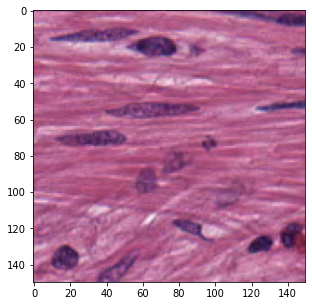

In [ ]:
img_id = 15
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(data[img_id])

Augmented versions:

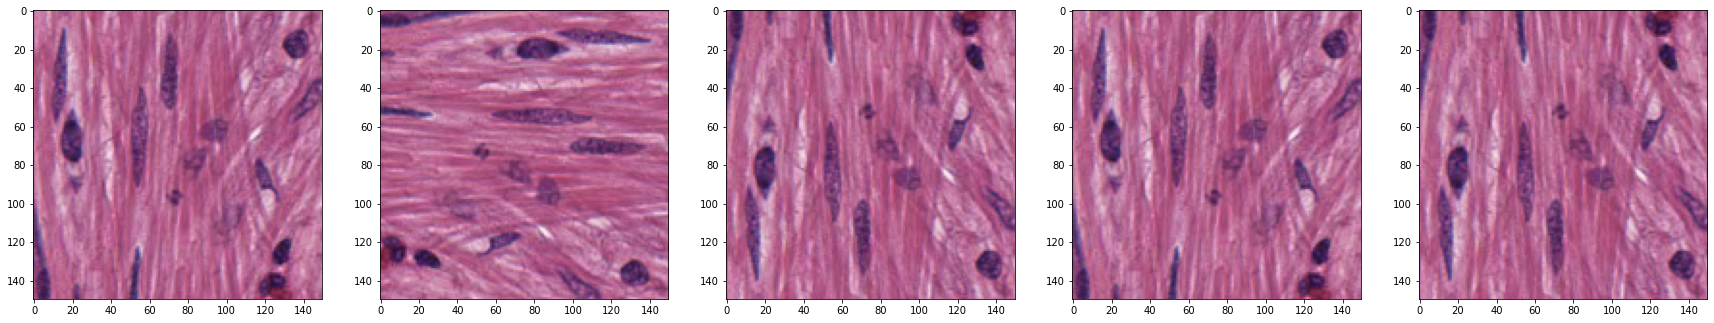

In [ ]:
img_generator = aug.flow(data[img_id:img_id+1], data[img_id:img_id+1], batch_size=1)
aug_gen = [next(img_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(30, 30))
l = [ax[i].imshow(aug_gen[i][0][0]) for i in range(0,5)]

### Definition of the model architecture

In [ ]:
base_model = Xception(input_shape = trainX.shape[1:], include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(3, activation="softmax")(x)
model = Model(base_model.input, x)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

### Model training

In [ ]:
# compile our model
BS = 3
EPOCHS = 50
opt = Adam(learning_rate=0.000001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
H = model.fit(
    #trainX, trainY,
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    epochs=EPOCHS)

Epoch 1/50
1270/1270 [==============================] - 35s 19ms/step - loss: 0.7336 - accuracy: 0.7151 - val_loss: 0.4901 - val_accuracy: 0.8510
Epoch 2/50
1270/1270 [==============================] - 21s 16ms/step - loss: 0.5243 - accuracy: 0.8375 - val_loss: 0.4131 - val_accuracy: 0.8930
Epoch 3/50
1270/1270 [==============================] - 21s 16ms/step - loss: 0.4410 - accuracy: 0.8745 - val_loss: 0.3667 - val_accuracy: 0.9056
Epoch 4/50
1270/1270 [==============================] - 21s 16ms/step - loss: 0.4077 - accuracy: 0.8842 - val_loss: 0.3403 - val_accuracy: 0.9119
Epoch 5/50
1270/1270 [==============================] - 21s 16ms/step - loss: 0.3745 - accuracy: 0.8895 - val_loss: 0.3148 - val_accuracy: 0.9192
Epoch 6/50
1270/1270 [==============================] - 21s 16ms/step - loss: 0.3447 - accuracy: 0.9021 - val_loss: 0.3115 - val_accuracy: 0.9171
Epoch 7/50
1270/1270 [==============================] - 21s 16ms/step - loss: 0.3086 - accuracy: 0.9155 - val_loss: 0.2855 -

### Plot model training progress

<function matplotlib.pyplot.show(close=None, block=None)>

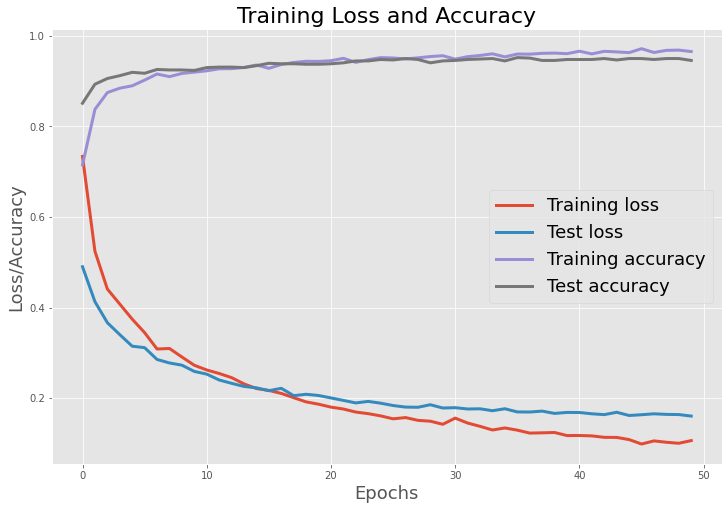

In [ ]:
N = EPOCHS
start = 0
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(np.arange(start, N), H.history["loss"][start:], label="Training loss", linewidth=3)
plt.plot(np.arange(start, N), H.history["val_loss"][start:], label="Test loss", linewidth=3)
plt.plot(np.arange(start, N), H.history["accuracy"][start:], label="Training accuracy", linewidth=3)
plt.plot(np.arange(start, N), H.history["val_accuracy"][start:], label="Test accuracy", linewidth=3)
plt.title("Training Loss and Accuracy", fontsize=22)
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss/Accuracy", fontsize=18)
plt.legend(loc="center right", fontsize=18)
plt.show

### Calculate business accuracy

In [ ]:
predictedY = model.predict(testX)
predictedY = (predictedY == predictedY.max(axis=1)[:,None]).astype(int)
accuracy = np.sum((predictedY == testY).all(1)) / len(testY)
print(f"Accuracy: {accuracy}")
business_accuracy = np.sum((predictedY[:, :2] == testY[:, :2]).all(1)) / len(testY)
print(f"Business accuracy: {business_accuracy}")

30/30 [==============================] - 2s 59ms/step
Accuracy: 0.9454354669464848
Business accuracy: 0.9454354669464848


### Store the model to google drive

In [ ]:
model.save('gdrive/MyDrive/Computer_Vision/model')